In [1]:
import torch
import torch.nn as nn
import sys
sys.path.append('../')
from model import ArgoLSTM
import torch.nn.functional as F
from torch.nn import MSELoss
from torch.optim import Adam
from tqdm import tqdm
import random
from torch.utils.data import Dataset, DataLoader

import os, os.path
import numpy as np
import pickle
from glob import glob
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
ROOT_PATH = "../argo2/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

In [3]:
# Randomly sample.
def get_city_trajectories(city="palo-alto", split="train"):
    f_in = ROOT_PATH + split + "/" + city + "_inputs"
    inputs = pickle.load(open(f_in, "rb"))
    inputs = np.asarray(inputs)
    
    outputs = None
    
    if split=="train":
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs, dtype=float)

    return inputs, outputs

In [4]:
def get_velocity(x):
    '''
    Get a difference vector to the given arguments.

    Parameters:
        x: array of size [N, T, 2] 
    Returns:
        x_vel: [N, T, 2]
    '''
    x_init = np.zeros((x.shape[0], 1, 2))
    x_vel = np.diff(x, axis=1)
    x_vel = np.concatenate((x_init, x_vel), axis=1)
    return x_vel

def get_vector(x):
    '''
    Get magnituude of change over x and y coordinates over time.

    Returns: x_vec: [N, T, 1]
    '''
    vel_init = np.zeros((x.shape[0], 1, 1))
    diff = np.diff(x, axis=1)
    delta = np.sqrt(np.sum(np.square(diff), axis=-1, keepdims=True))
    vec = np.concatenate((vel_init, delta), axis=1)
    return vec

def add_channel(a, b):
    '''Adds a channel along last axis'''
    return np.concatenate((a, b), axis=-1)

In [5]:
def get_all_city_trajectories(split="train"):
    X = None
    Y = None
    for city in cities:
        x, y = get_city_trajectories(city, split)
        if X is None:
            X = x
            Y = y
        else:
            X = np.concatenate([X, x], axis=0)
            Y = np.concatenate([Y, y], axis=0)
    return X, Y

In [6]:
def scale(x, scaler):
    '''Scale x'''
    return scaler.transform(x.reshape(-1, 2)).reshape(-1, x.shape[1], 2)

In [7]:
class ArgoDataset(Dataset):
    def __init__(self, X, Y, scaler=None, train=True):
        '''
        X: array of first 6 seconds with shape (N, 50, 2)
        Y: array of first 5 seconds with shape (N, 60, 2)
        transform: sklearn scaler for now.
        '''
        self.X, self.Y = X, Y
        self.train = train
        self.scaler = scaler
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x, y = self.X[idx].astype(np.float32), self.Y[idx].astype(np.float32)
        x = torch.from_numpy(x)
        y = torch.from_numpy(y)

        return x, y

    def inverse_transform(self, x):
        out = self.scaler.inverse_transform(x.reshape(-1, 2)).reshape(-1, x.shape[1], 2)
        return out


In [8]:
seed = 0
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

EPOCHS = 500
BATCH_SIZE = 256 # batch size
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.01
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

X, Y = get_all_city_trajectories()
x_vel, y_vel = get_velocity(X), get_velocity(Y)
x_vec, y_vec = get_vector(X), get_vector(Y)

# Scale to train data
scaler=None
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=seed)
scaler = MinMaxScaler(feature_range=(0, 10000))
scaler.fit(x_train.reshape(-1, 2))
scaler.fit(y_train.reshape(-1, 2))

# Process
X_, Y_ = scale(X, scaler), scale(Y, scaler)
X_, Y_ = add_channel(X_, x_vel), add_channel(Y_, y_vel)
X_, Y_ = add_channel(X_, x_vec), add_channel(Y_, y_vec)

print(f"X shape {X.shape}, Y shape {Y.shape}")
x_train, x_val, y_train, y_val = train_test_split(X_, Y_, test_size=0.2, random_state=seed)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=seed)


train_dataset  = ArgoDataset(x_train, y_train, scaler, train=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True)
val_dataset = ArgoDataset(x_val, y_val, scaler, train=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, drop_last=True)

size = 5
model = ArgoLSTM(BATCH_SIZE, input_size=size, output_size=size)
model.to(DEVICE)

# criterion = nn.MSELoss()
# criterion = nn.L1Loss()

mse = nn.MSELoss()
mae = nn.L1Loss()

def criterion(output, target):
    # return mse(output, target) + mae(output, target)
    return mae(output, target)


opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)


In [ ]:
def step(model, criterion, opt, loader, split):
    if split == "train":
        model.train()
    elif split == "eval":
        model.eval()

    def step_epoch():
        running_loss = 0
        for i, (x, y) in enumerate(loader):
            x, y = x.to(DEVICE), y.to(DEVICE)
            hidden = model.init_Hidden(DEVICE)

            out, hidden = model(x, hidden)
            out, hidden = model(y, hidden)

            loss = criterion(out, y)
            running_loss += loss.item()

            if split=="train":
                opt.zero_grad()
                loss.backward()
                opt.step()
            
        return running_loss / BATCH_SIZE

    if split == "train":
        return step_epoch()
    elif split == "eval":
        with torch.no_grad():
            return step_epoch()

def run(model, criterion, opt, train_loader, val_loader):
    train_losses = []
    val_losses = []
    progress = tqdm(range(EPOCHS))
    for e in progress:
        train_loss = step(model, criterion, opt, train_loader, split="train")
        val_loss = step(model, criterion, opt, val_loader, split="eval")
        progress.set_description(f"Train MAE: {train_loss} Val MAE: {val_loss}")
        train_losses.append(train_loss)
        val_losses.append(val_loss)

    return train_losses, val_losses

In [40]:
train_losses, val_losses = run(model, criterion, opt, train_loader, val_loader)

Train MAE: 4073.1588621139526 Val MAE: 504.5090079307556: 100%|██████████| 500/500 [21:28<00:00,  2.58s/it] 


In [11]:
torch.save(model, 'model.pt')
# model.load_state_dict(torch.load('model.pt'))

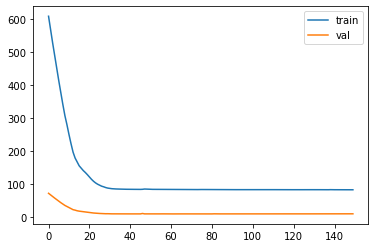

In [28]:
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.show()

In [29]:
def plot_examples(x, y, pred):
    n = 10
    fig, axs = plt.subplots(n, 2, figsize=(10, 20))

    for i in range(n):
        axs[i, 0].scatter(x[i, :, 0], x[i, :, 1], label='input', c='blue')
        axs[i, 0].scatter(y[i, :, 0], y[i, :, 1], label='output', c='orange')

        axs[i, 1].scatter(x[i, :, 0], x[i, :, 1], label='input', c='blue')
        axs[i, 1].scatter(pred[i, :, 0], pred[i, :, 1], label='prediction', c='green')
        axs[i, 1].set_title('Prediction')
        axs[i, 1].legend()

        plt.tight_layout()

In [30]:
def plot_train(model, loader):
    running_loss = 0
    for i, (x, y) in enumerate(loader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        hidden = model.init_Hidden(DEVICE)

        out, hidden = model(x, hidden)
        out, hidden = model(y, hidden)

        loss = criterion(out, y)
        running_loss += loss.item()


        plot_examples(x.detach().cpu(), y.detach().cpu(), out.detach().cpu())

        break

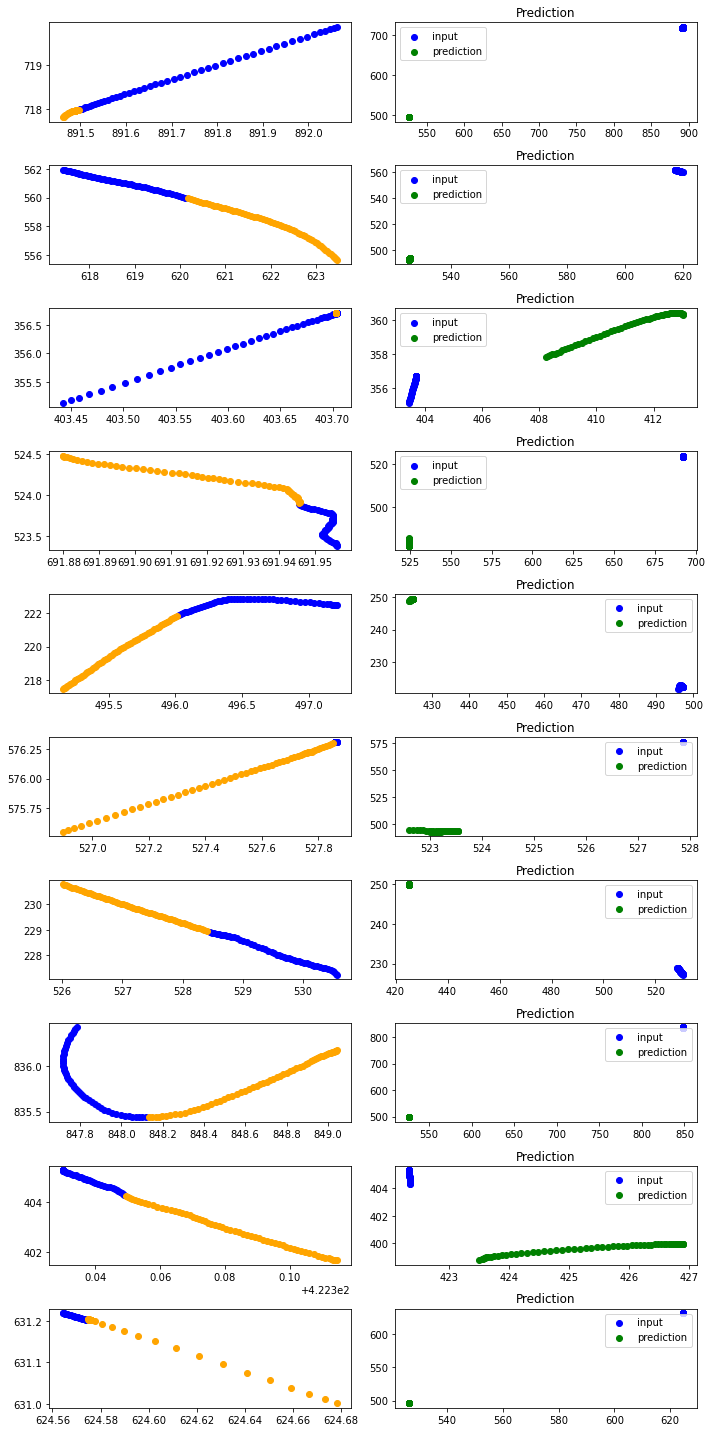

In [31]:
plot_train(model, train_loader)

In [147]:
class ArgoTestset(Dataset):
    def __init__(self, X, Y, scaler=None):
        '''
        X: array of first 6 seconds with shape (N, 50, 2)
        Y: array of first 5 seconds with shape (N, 60, 2)
        transform: sklearn scaler for now.
        '''
        self.X, self.Y = X, Y
        self.scaler = scaler

        # if scaler is not None:
        #     # Transform first 2 elements in last axis.
        #     self.X = self._transform(X)
        #     self.Y = self._transform(Y)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x, y = self.X[idx].astype(np.float32), self.Y[idx].astype(np.float32)
        x = torch.from_numpy(x)
        y = torch.from_numpy(y)

        return x, y

    def _transform(self, x):
        coords, vel = x[:, :, :2], x[:, :, 2:]
        coords_normalized = self.scaler.transform(coords.reshape(-1, 2)).reshape(-1, coords.shape[1], 2)
        transformed = add_channel(coords_normalized, vel)
        return transformed

    def inverse_transform(self, x):
        out = self.scaler.inverse_transform(x.reshape(-1, 2)).reshape(-1, x.shape[1], 2)
        return out


In [148]:
# Plot predictions

test_dataset = ArgoTestset(x_test, y_test, train_dataset.scaler)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, drop_last=True)

In [149]:
test_loss = step(model, criterion, opt, test_loader, split="eval")
print("Test loss:", test_loss)

Test loss: 59.33345991373062


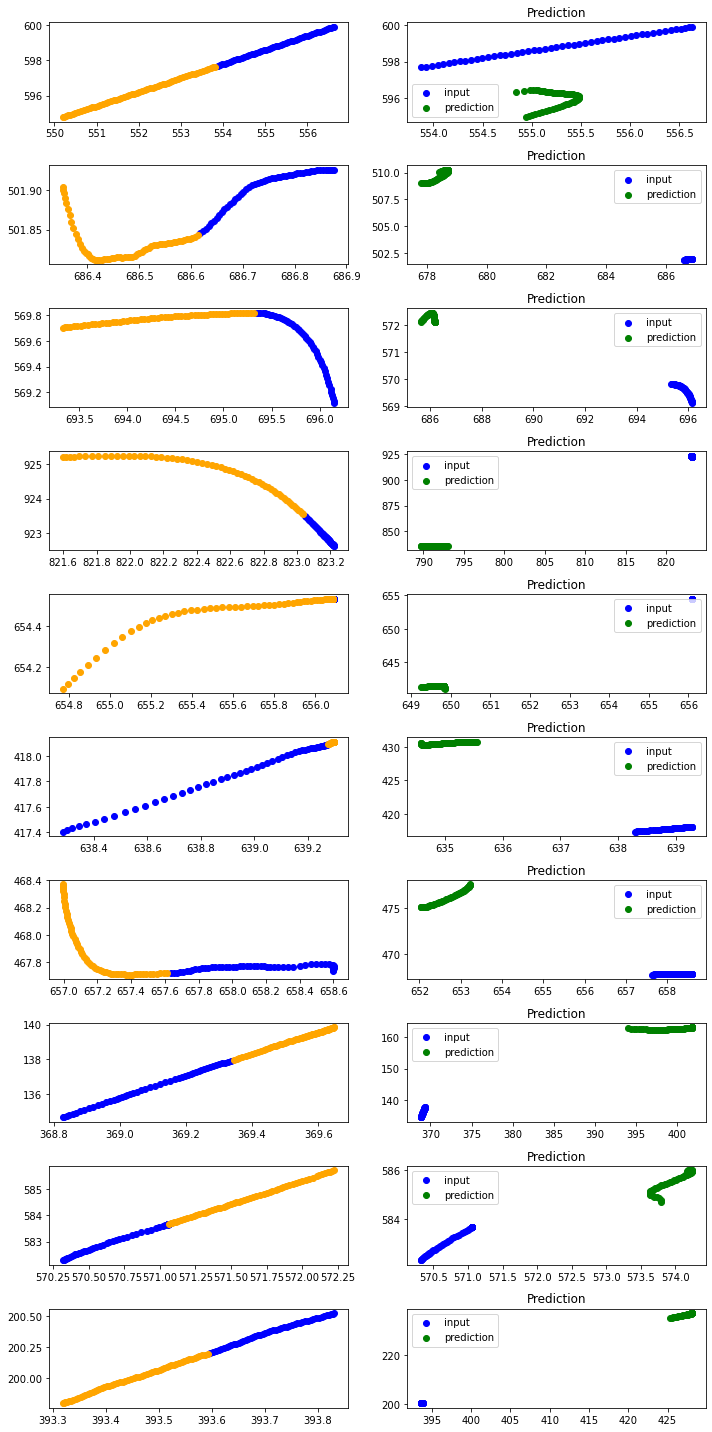

In [150]:
def plot_test(model, loader):
    model.eval()
    criterion = nn.MSELoss(reduction="none")
    losses = []

    for i, (x, y) in enumerate(loader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        hidden = model.init_Hidden(DEVICE)

        out, hidden = model(x, hidden)
        out, hidden = model(y, hidden)

        loss = criterion(out, y)
        losses = loss.mean(axis=(1, 2))
        
        plot_examples(x.detach().cpu(), y.detach().cpu(), out.detach().cpu())

        break

plot_test(model, test_loader)